Install the cloud-vision library using pip / conda, we're gonna use it in calling the client to use the OCR engine

In [1]:
!pip install google-cloud-vision


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Importing the necessary libraries

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import io

Here we're using OpenCV to crop and adjust the input image for the OCR engine to detect the text present in the image. Gotta play with the factors, and  adjust accordingly, but for the majority you'll want it such that, maximum gradient is maintained and only the required text part is being kept and all the unnecessary parts are removed

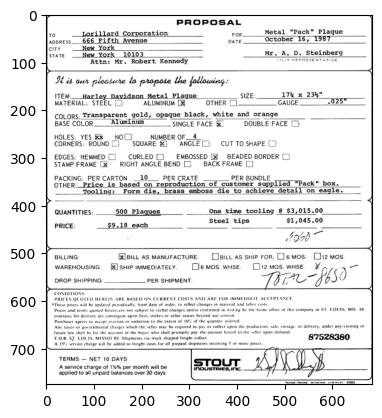

True

In [3]:
# Read the image
image = cv2.imread('form_example.png')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blur, 50, 150)

# Perform morphological operations to close gaps in edges
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# Find contours in the closed image
contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on area and aspect ratio to extract potential tables
min_table_area = 1000  # Minimum table area to filter out small contours
min_aspect_ratio = 0.3  # Minimum aspect ratio to filter out non-table contours
tables = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)
    aspect_ratio = w / float(h)

    if area > min_table_area and aspect_ratio > min_aspect_ratio:
        tables.append((x, y, x + w, y + h))


# Sort the tables list based on the area in descending order
tables.sort(key=lambda table: (table[2] - table[0]) * (table[3] - table[1]), reverse=True)

# Access the bounding coordinates of the largest table
x1, y1, x2, y2 = tables[0]

# Extract the sub-image
largest_table = image[y1:y2, x1:x2]
type(largest_table)
# Display the largest table
plt.imshow(largest_table)
plt.show()


cv2.imwrite('Cropped_largest_table.png', largest_table)

Now we can display all the detected 'tables' which contain text and using the co-ordinates we can extract text from that particular rectangle/bounding box

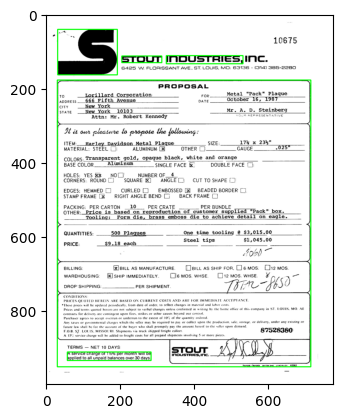

In [4]:
# Draw rectangles around the detected tables
for table in tables:
    x1, y1, x2, y2 = table
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the result
plt.imshow(image)
plt.show()

Now we use the vision library from google-cloud-vision and use the ImageAnnotatorClient to call the OCR engine and feed the image and return the text extracted

In [5]:
from google.cloud import vision
from google.cloud.vision_v1 import types

# Set the path to your secure access key JSON file
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'credentials.json'

# Path to the input JPEG file
image_path = 'D:\code\Cropped_largest_table.png'

client = vision.ImageAnnotatorClient()

ext = os.path.splitext(image_path)[-1].lower()

image_name = image_path

# Read the image file
with io.open(image_name, 'rb') as image_file:
    content = image_file.read()

image = types.Image(content=content)

lines = []
# Perform OCR on the image
response = client.document_text_detection(image=image)
doc = response.full_text_annotation

775 684 3


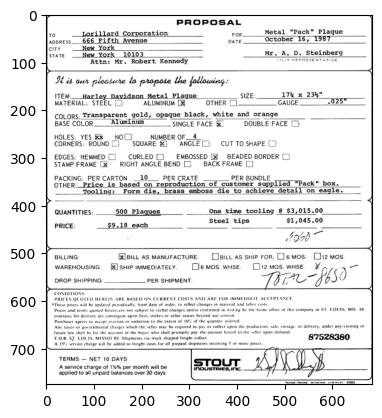

In [6]:
img = cv2.imread('Cropped_largest_table.png')
height, width, channel = img.shape

print(height, width, channel)

plt.imshow(img)
plt.show()

But the text extracted is an TextAnnotation object, so we need the coordinates of the bounding_poly.vertices to extract the text 'line by line' from the image. 

Note: This portion requires a strong trial and error planning to get the exact text in the ordering. The bounds that you place for the X and Y axis, determine the text ordering that we get.
Someone could devise an algorithm to get the best possible error reduction values for the ideal extraction, but remember to check the dimension of the input image as a change in that, would affect the calculations!

In [7]:
items = []
lines = {}

min_top_x_axis = 0
min_top_y_axis = 0
for text in response.text_annotations[1:]:
  top_x_axis = text.bounding_poly.vertices[0].x
  top_y_axis = text.bounding_poly.vertices[0].y
  bottom_y_axis = text.bounding_poly.vertices[3].y

  if top_y_axis not in lines:
    lines[top_y_axis] = [(top_y_axis, bottom_y_axis), []]

  for k, v in lines.items():
    if top_y_axis <= v[0][0] and top_y_axis < 2157 and top_x_axis < width:
      if bottom_y_axis >= v[0][1]:
        lines[k][1].append((top_x_axis, text.description))
        break

for _, item in lines.items():
  if item[1]:
    words = item[1]
    items.append(' '.join([word for _, word in words]))   

Finally we can print the list containing the text from the image, which can be further used for any other applications!

In [8]:
for item in items:
  print(item, '\n')

CITY 

STATE 

Lorillard 

Corporation 

TO 

ADDRESS 

666 

New 

York 

New 

10103 

Attn 

Kennedy 

It is our pleasure following 

to 

propose : 

ITEM : Harley Davidson Metal Plaque SIZE 

MATERIAL : STEEL . OTHER O. GAUGE 

ALUMINUM 

HOLES : YES ** NO NUMBER 

CORNERS ANGLE CUT TO SHAPE [ ! 

QUANTITIES : 

PRICE 

BILLING : X BILL AS MANUFACTURE . BILL AS SHIP FOR , 6 MOS . 12 MOS . 

SQUARE 

EDGES 

CURLED EMBOSSED BEADED BORDER 

STAMP 

RIGHT ANGLE BEND BACK FRAME 

PROPOSAL 

WAREHOUSING 

DROP SHIPPING : PER SHIPMENT . TOTAR - 8650 

COLORS 

gold , opaque 

and orange 

BASE 

COLOR 

Aluminum 

SINGLE 

DOUBLE FACE 

the 

4 

500 Plaques 

$ 9.18 each 

XSHIP IMMEDIATELY .. 

DATE 

10 PER CRATE PACKING : PER CARTON PER BUNDLE 

OTHER 

based 

reproduction 

supplied " Pack " 

box . 

Tooling 

Form die , brass emboss die to achieve detail on eagle . 

TERMS NET 10 DAYS 

A service charge of 1 % % per month will be 

applied to all unpaid balances over 30 days . 
